In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import time
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics 

import warnings
warnings.filterwarnings("ignore")
#matplot lib notebooks display command
%matplotlib inline

#SET OPTIONS
pd.options.display.float_format = '{:,.2f}'.format
#GLOBAL VARIABLES
today = datetime.date.today()
#cwd = os.getcwd()

In [2]:
clean_df = pd.read_csv('../Data/clean_with_collector_df.csv', encoding='utf-8')
clean_df = clean_df.drop(columns = 'Unnamed: 0')
print("done")

done


# Linear Regression 

### split data

In [3]:
def split_data(clean_df):

    X = clean_df.loc[:, clean_df.columns != "DAYS_TO_PAY"]
    y = clean_df['DAYS_TO_PAY']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
    print("done")
    return X_train, X_valid, y_train, y_valid,  X_test, y_test


## Choose best features with SelectKBest

In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression


def find_best_features(clean_df, X_train, y_train, X_valid, y_valid):
    error_lst = []
    for k in range(1, len(clean_df.dtypes)):
    
        k_best = SelectKBest(f_regression, k=k)
        X_new = k_best.fit_transform(X_train, y_train)
        #print(X_new)
        X_new_valid = k_best.transform(X_valid)
        #print(X_new_valid)
        clf = linear_model.LinearRegression(normalize = True, fit_intercept = True)
        clf.fit(X_new, y_train)
        y_new= clf.predict(X_new_valid)
        mae = metrics.mean_absolute_error(y_valid, y_new)
        #print(mae)
        error_lst.append(mae)
    graph_K_best(error_lst)
    return  SelectKBest(f_regression, error_lst.index(min(error_lst))).fit(X_train, y_train)

    


### Graph K best features

In [5]:
def graph_K_best(mae_list):
    reg_coef_list = range(1, len(clean_df.dtypes))
    plt.plot(reg_coef_list, mae_list)
    plt.axvline(x=reg_coef_list[mae_list.index(min(mae_list))], color='orange', linestyle='--', 
            label='Min: Coef = {}'.format(reg_coef_list[mae_list.index(min(mae_list))])+' | error = {}'.format(min(mae_list)))
    plt.title("Effect of K Best Coefficients on MAE")
    plt.xlabel("K best coefficients")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()
    return(min(mae_list))

### Graph Ridge Regression

In [6]:

def graph_RR(reg_coef_list, X_train, y_train, X_valid, y_valid):
    print("executed start")
     #np.concatenate( (np.arange(0.05, 1.0, 0.05),np.arange(1, 10.0, 1)), axis=None) 
    mae_list = []

    for coef in reg_coef_list:
        start = time.process_time()
        linreg = linear_model.Ridge(normalize = True, alpha=coef, max_iter=5000, fit_intercept = True)
        linreg.fit(X=X_train, y=y_train)
        y_pred = linreg.predict(X_valid)
        mae = metrics.mean_absolute_error(y_valid, y_pred)
        #print(mae)
        mae_list.append(mae)
        end = time.process_time()
        #print('Model using '+str(coef)+' as the regularization coefficient completed in '+str(round(end-start,3))+'sec')

    plt.plot(reg_coef_list, mae_list)
    plt.axvline(x=reg_coef_list[mae_list.index(min(mae_list))], color='orange', linestyle='--', 
            label='Min: Coef = {}'.format(reg_coef_list[mae_list.index(min(mae_list))])+' | Accuracy = {}'.format(min(mae_list)))
    plt.title("Regularization Coefficient Effect on MAE")
    plt.xlabel("Regularization Coef")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()
    print ("min error is ",min(mae_list))
    return reg_coef_list[mae_list.index(min(mae_list))]



### Visualize Final Graph

In [7]:
def visualize_best_model(title, alpha, X_train, y_train, X_test, y_test):

    linreg = linear_model.Ridge(normalize = True, alpha=alpha, max_iter=5000)
    linreg.fit(X_train, y_train)
    y_valid_pred = linreg.predict(X_valid)
    print("Validation error is ", metrics.mean_absolute_error(y_valid, y_valid_pred))
    y_pred = linreg.predict(X_test)
    print("Test error is ", metrics.mean_absolute_error(y_test, y_pred))
    #visualization code from https://matplotlib.org/gallery/api/two_scales.html

    color = 'tab:red'

    fig, pred_plot = plt.subplots(figsize=(10,5))
    pred_plot.set_xlabel("Days to Pay", color='black')
    pred_plot.set_ylabel("Predicted Lateness", color=color)
    pred_plot.plot(y_test, y_pred, 'ro')
    pred_plot.tick_params(axis='y', labelcolor=color)

    pred_ax = pred_plot.twinx()

    color = 'tab:blue'
    pred_ax.set_ylabel('Acutal Lateness', color=color)  # we already handled the x-label with ax1
    pred_ax.plot(y_test, y_test, 'bo')
    pred_ax.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    title = title+": Variation in Predicted Lateness Given Actual Lateness"
    plt.title(title)
    plt.show()

In [8]:
def feature_selection(df):
    X_train, X_valid, y_train, y_valid,  X_test, y_test = split_data(df)
    kbest = find_best_features(clean_df, X_train, y_train, X_valid, y_valid)
    X_train = kbest.transform(X_train)
    X_valid = kbest.transform(X_valid)
    X_test = kbest.transform(X_test)
    return X_train, X_valid, X_test, y_train, y_valid, y_test
    
    
def regularization(title, reg_coef_list, X_train, X_valid, X_test, y_train, y_valid, y_test):
    alpha = graph_RR(reg_coef_list, X_train, y_train, X_valid, y_valid)
    visualize_best_model(title, alpha, X_train, y_train, X_test, y_test)
    

# Regressing Entire Dataset

done


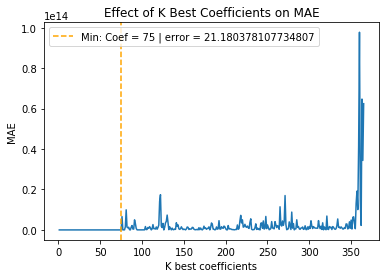

In [93]:
X_train, X_valid, X_test, y_train, y_valid, y_test = feature_selection(clean_df)

done
executed start


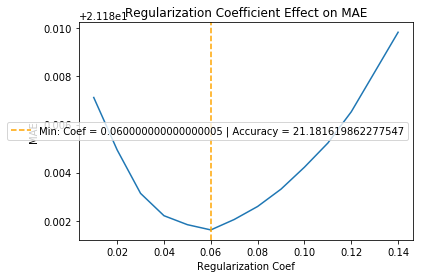

min error is  21.181619862277547
Validation error is  21.181619862277547
Test error is  22.428784773321475


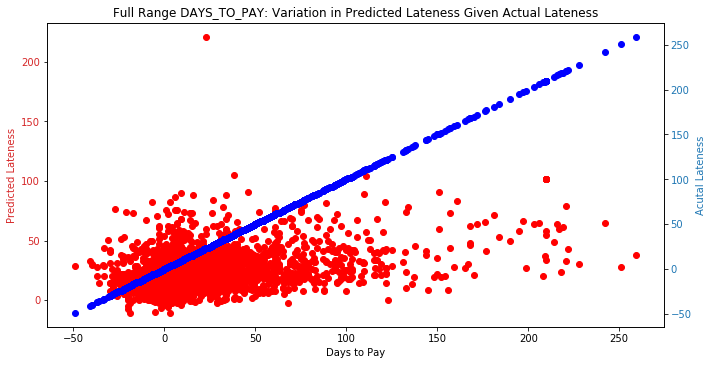

In [95]:
reg_coef_list = np.arange(.01, .15, .01)
print('done')
regularization("Full Range DAYS_TO_PAY", reg_coef_list, X_train, X_valid, X_test, y_train, y_valid, y_test)

# Selecting Best Feature

In [10]:
X_train, X_valid, y_train, y_valid,  X_test, y_test = split_data(clean_df)

done


(10133, 365)
(10133,)
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


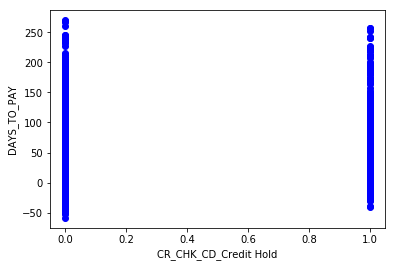

23.188373041949376


array([15])

In [11]:
best3 = SelectKBest(f_regression, k=1)
print(X_train.shape)
print(y_train.shape)
X_new = best3.fit_transform(X_train, y_train)
print(X_new)
plt.plot(X_new, y_train, 'bo')
plt.xlabel("CR_CHK_CD_Credit Hold")
plt.ylabel("DAYS_TO_PAY")
plt.show()


X_new_valid = best3.transform(X_valid)
#print(X_new_valid)
clf = linear_model.LinearRegression(normalize = True, fit_intercept = True)
clf.fit(X_new, y_train)
y_new= clf.predict(X_new_valid)
mae = metrics.mean_absolute_error(y_valid, y_new)
print(mae)

best3.get_support(indices = True)

In [75]:
i=0
for el in clean_df.columns:
    print(i)
    print(el)
    i += 1

0
PYDX_SCRE_NUM
1
CURR_NUM_LICENSES
2
TRUE_LOGIN
3
USAGE_SCORE
4
EMP_CNT
5
CUSTOMER_REVENUE
6
HAS_TAX_EXEMP
7
HAS_30DAY_EXTXN
8
PAST_DUE_FLG
9
DAYS_TO_PAY
10
TOTAL_AMOUNT
11
CR_CHK_CD_0
12
CR_CHK_CD_Approved
13
CR_CHK_CD_Bankruptcy
14
CR_CHK_CD_Credit Data Not Found
15
CR_CHK_CD_Credit Hold
16
CR_CHK_CD_Defer Revenue
17
CR_CHK_CD_Payment Plan
18
CR_CHK_CD_Prepayment
19
CUST_STAT_Attrited Customer
20
CUST_STAT_Direct Customer
21
CUST_STAT_Indirect Customer
22
CUST_STAT_Prospect
23
INDUSTRY_NM_0
24
INDUSTRY_NM_Aerospace & Defense
25
INDUSTRY_NM_Agriculture & Mining
26
INDUSTRY_NM_Automotive
27
INDUSTRY_NM_Business Services
28
INDUSTRY_NM_Communications
29
INDUSTRY_NM_Consulting
30
INDUSTRY_NM_Education
31
INDUSTRY_NM_Energy & Utilities
32
INDUSTRY_NM_Engineering, Construction, & Real Estate
33
INDUSTRY_NM_Financial_Services
34
INDUSTRY_NM_Health_Care
35
INDUSTRY_NM_High_Tech
36
INDUSTRY_NM_Hospitality, Travel, & Transportation
37
INDUSTRY_NM_Manufacturing
38
INDUSTRY_NM_Nonprofit Institu

done
executed start


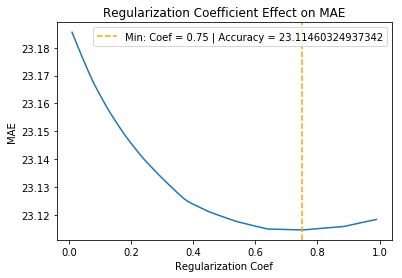

min error is  23.11460324937342
Validation error is  23.11460324937342
Test error is  24.19975739972748


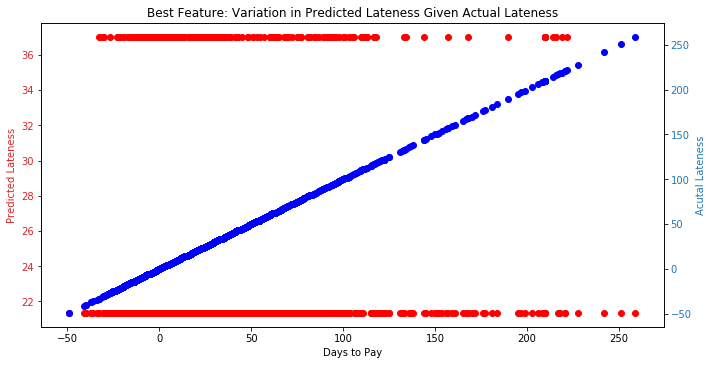

In [99]:
X_train = best3.transform(X_train)
X_valid = best3.transform(X_valid)
X_test = best3.transform(X_test)


reg_coef_list = np.arange(.01, 1, .01)
print('done')
regularization("Best Feature", reg_coef_list, X_train, X_new_valid, X_test, y_train, y_valid, y_test)




# Selecting the three best features

done
(10133, 365)
(10133,)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


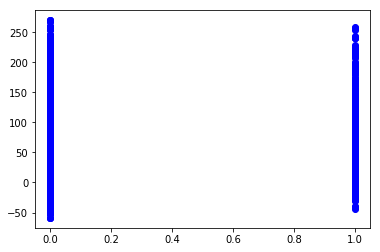

22.99148308470933
done
executed start


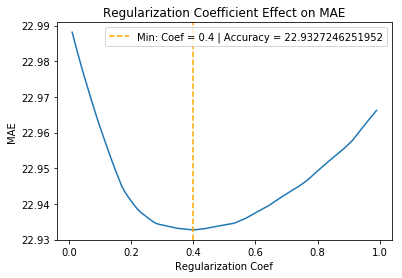

min error is  22.9327246251952
Validation error is  22.9327246251952
Test error is  23.95933679752021


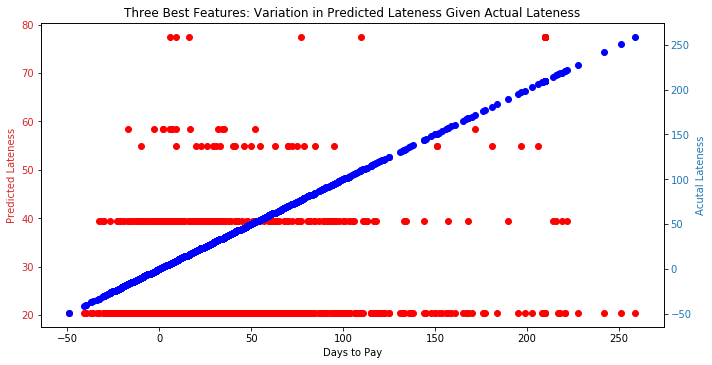

In [101]:
X_train, X_valid, y_train, y_valid,  X_test, y_test = split_data(clean_df)
best3 = SelectKBest(f_regression, k=3)
print(X_train.shape)
print(y_train.shape)
X_new = best3.fit_transform(X_train, y_train)
print(X_new)
plt.plot(X_new, y_train, 'bo')
plt.show()


X_new_valid = best3.transform(X_valid)
#print(X_new_valid)
clf = linear_model.LinearRegression(normalize = True, fit_intercept = True)
clf.fit(X_new, y_train)
y_new= clf.predict(X_new_valid)
mae = metrics.mean_absolute_error(y_valid, y_new)
print(mae)


X_train = best3.transform(X_train)
X_valid = best3.transform(X_valid)
X_test = best3.transform(X_test)


reg_coef_list = np.arange(.01, 1, .01)
print('done')
regularization("Three Best Features", reg_coef_list, X_train, X_new_valid, X_test, y_train, y_valid, y_test)




In [84]:
best3.get_support(indices = True)

array([ 15, 198, 239])

# Early Payment

In [9]:
clean_df1 = clean_df.drop(index = clean_df.loc[lambda df: df['DAYS_TO_PAY'] > 0].index).reset_index()
for el in pd.unique(clean_df1['DAYS_TO_PAY']):
    print(el)

-59.0
-9.0
-17.0
-20.0
-12.0
-1.0
-4.0
-2.0
-3.0
-25.0
-10.0
-27.0
-23.0
-8.0
-6.0
-5.0
-7.0
-11.0
0.0
-16.0
-13.0
-24.0
-19.0
-35.0
-28.0
-15.0
-18.0
-14.0
-22.0
-30.0
-21.0
-26.0
-44.0
-33.0
-29.0
-45.0
-51.0
-42.0
-43.0
-34.0
-37.0
-31.0
-40.0
-32.0
-36.0
-49.0
-39.0
-53.0
-41.0
-46.0


In [10]:
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(clean_df1)


done


In [24]:
reg_coef_list = np.arange(.001, .01, .001)
print('done')
regularization("Early Payment", reg_coef_list, X_train, X_valid, X_test, y_train, y_valid, y_test)

done
executed start


ValueError: Found input variables with inconsistent numbers of samples: [2226, 557]

# Predicting Late Payment

In [47]:
clean_df2 = clean_df.drop(index = clean_df.loc[lambda df: df['DAYS_TO_PAY'] < 0].index).reset_index()
for el in pd.unique(clean_df2['DAYS_TO_PAY']):
    print(el)

95.0
5.0
10.0
13.0
2.0
8.0
36.0
51.0
79.0
3.0
11.0
40.0
25.0
123.0
41.0
15.0
12.0
19.0
6.0
29.0
27.0
46.0
16.0
1.0
84.0
61.0
17.0
38.0
53.0
9.0
55.0
20.0
117.0
32.0
22.0
60.0
70.0
42.0
4.0
82.0
37.0
102.0
67.0
26.0
34.0
113.0
33.0
43.0
49.0
65.0
21.0
45.0
39.0
7.0
54.0
56.0
72.0
14.0
44.0
210.0
88.0
62.0
35.0
63.0
179.0
52.0
24.0
68.0
251.0
112.0
57.0
23.0
50.0
48.0
28.0
0.0
121.0
81.0
18.0
74.0
47.0
89.0
160.0
31.0
246.0
77.0
119.0
80.0
203.0
59.0
143.0
92.0
122.0
91.0
58.0
66.0
73.0
93.0
71.0
30.0
87.0
86.0
120.0
180.0
149.0
147.0
130.0
125.0
111.0
99.0
168.0
148.0
105.0
126.0
153.0
76.0
140.0
78.0
190.0
100.0
186.0
98.0
103.0
144.0
109.0
97.0
135.0
193.0
136.0
127.0
101.0
173.0
138.0
145.0
199.0
132.0
108.0
141.0
129.0
96.0
85.0
202.0
75.0
169.0
114.0
154.0
128.0
69.0
221.0
137.0
253.0
182.0
234.0
116.0
268.0
146.0
155.0
64.0
164.0
191.0
163.0
90.0
106.0
240.0
183.0
83.0
167.0
216.0
104.0
171.0
187.0
241.0
214.0
94.0
184.0
142.0
157.0
269.0
124.0
176.0
222.0
170.0
185.0
110.0
195.0


done


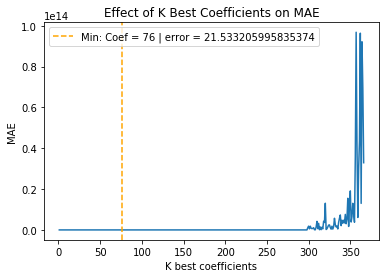

In [48]:
X_train, X_valid, X_test, y_train, y_valid, y_test = feature_selection(clean_df2)


done
executed start
Model using 1e-14 as the regularization coefficient completed in 0.02sec


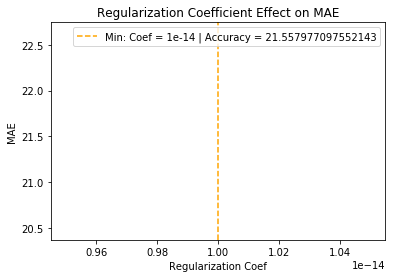

min error is  21.557977097552143
MAE is  21.61870323223412


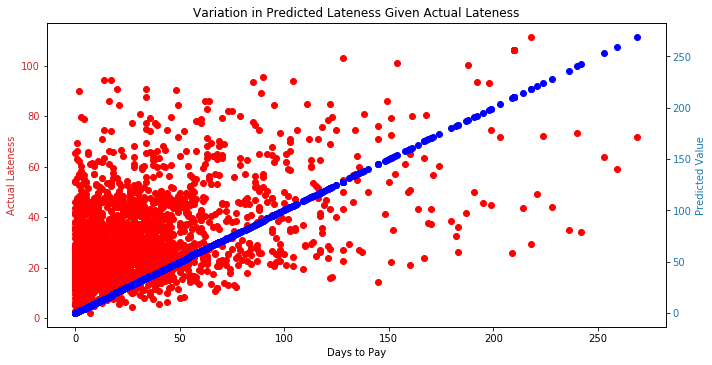

In [69]:
reg_coef_list = np.arange(.00000000000001, .00000000001, .00000000001)
print('done')
regularization(reg_coef_list, X_train, X_valid, X_test, y_train, y_valid, y_test)

# Linear Regression for first 30 days

In [83]:
clean_df0_30 = clean_df1.drop(index = clean_df1.loc[lambda df: df['DAYS_TO_PAY'] >30].index)
for el in pd.unique(clean_df0_30['DAYS_TO_PAY']):
    print(el)

NameError: name 'clean_df1' is not defined

done


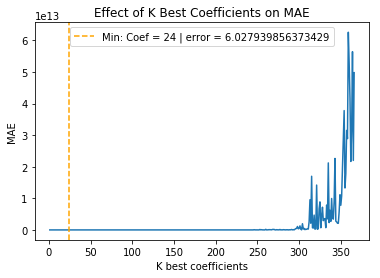

In [71]:
X_train, X_valid, X_test, y_train, y_valid, y_test = feature_selection(clean_df0_30)


done
executed start
Model using 0.001 as the regularization coefficient completed in 0.006sec
Model using 0.006 as the regularization coefficient completed in 0.004sec
Model using 0.011 as the regularization coefficient completed in 0.004sec
Model using 0.016 as the regularization coefficient completed in 0.004sec
Model using 0.021 as the regularization coefficient completed in 0.005sec
Model using 0.026000000000000002 as the regularization coefficient completed in 0.005sec
Model using 0.031 as the regularization coefficient completed in 0.005sec
Model using 0.036000000000000004 as the regularization coefficient completed in 0.005sec
Model using 0.041 as the regularization coefficient completed in 0.004sec
Model using 0.046 as the regularization coefficient completed in 0.005sec


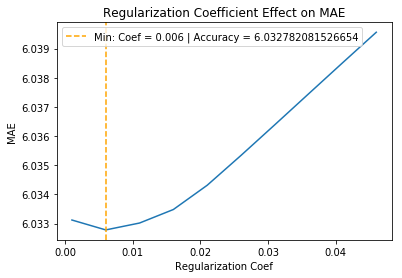

min error is  6.032782081526654
MAE is  6.370201407928742


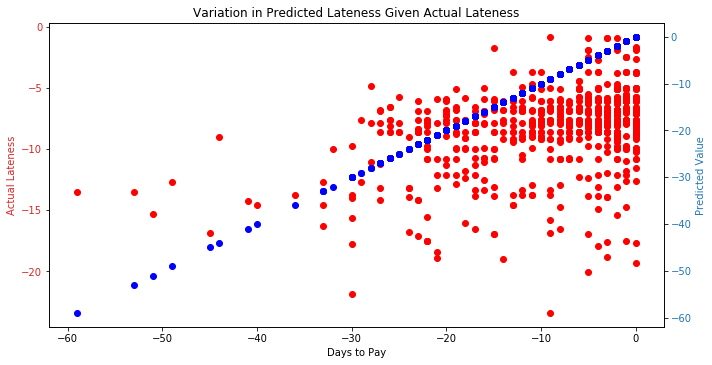

In [72]:
reg_coef_list = np.arange(.001, .05, .005)
print('done')
regularization(reg_coef_list, X_train, X_valid, X_test, y_train, y_valid, y_test)

# Between 30 and 60 days late

In [75]:
clean_df30_60 = clean_df.drop(index = \
                clean_df.loc[lambda df: 30 > df['DAYS_TO_PAY'] ].index)

clean_df30_60 = clean_df30_60.drop(index = \
                clean_df30_60.loc[lambda df:  df['DAYS_TO_PAY'] > 60].index)

for el in pd.unique(clean_df30_60['DAYS_TO_PAY']):
    print(el)

36.0
51.0
40.0
41.0
46.0
38.0
53.0
55.0
32.0
60.0
42.0
37.0
34.0
33.0
43.0
49.0
45.0
39.0
54.0
56.0
44.0
35.0
52.0
57.0
50.0
48.0
47.0
31.0
59.0
58.0
30.0


done


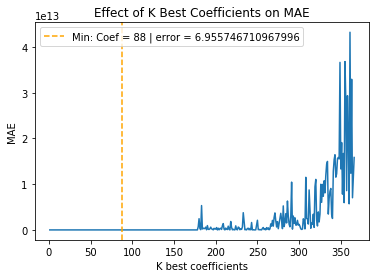

In [76]:
X_train, X_valid, X_test, y_train, y_valid, y_test = feature_selection(clean_df30_60)


done
executed start
Model using 0.001 as the regularization coefficient completed in 0.01sec
Model using 0.101 as the regularization coefficient completed in 0.009sec
Model using 0.201 as the regularization coefficient completed in 0.009sec
Model using 0.30100000000000005 as the regularization coefficient completed in 0.009sec
Model using 0.401 as the regularization coefficient completed in 0.009sec
Model using 0.501 as the regularization coefficient completed in 0.009sec
Model using 0.6010000000000001 as the regularization coefficient completed in 0.009sec
Model using 0.7010000000000001 as the regularization coefficient completed in 0.009sec
Model using 0.801 as the regularization coefficient completed in 0.01sec


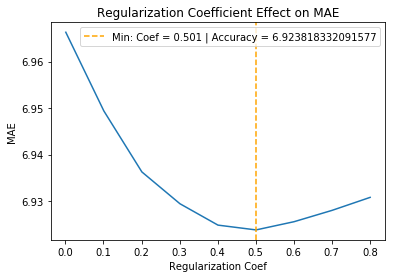

min error is  6.923818332091577
MAE is  7.018017008237742


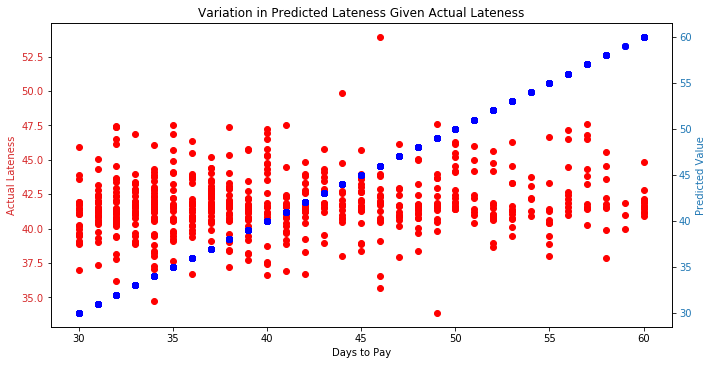

In [79]:
reg_coef_list = np.arange(.001, .9, .1)
print('done')
regularization(reg_coef_list, X_train, X_valid, X_test, y_train, y_valid, y_test)